In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, prange

import sys

sys.path.append('../modules/')

import funAdapt as fa

In [63]:
Nsteps = int(1e7)
dt = 1e-3

sigma = 1.5
theta_eta = 3.
tau_a = 1.
sigma_a = 0.1
Lambda = 0.9

a = 1.

x0 = 0.
y0 = 0.
eta0 = 0.

tau_x = 1.
theta_y = 1.

expected_cov = fa.cov_matrix(sigma, theta_eta, a)
#L, _, _, _, _, _ = fa.find_functional(Nsteps, dt, sigma, a, theta_eta, Lambda, x0, y0, eta0, tau_x = tau_x, theta_y = theta_y)

In [64]:
x, y, eta = fa.simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, x0 = 0, y0 = 0, eta0 = 0)
np.cov([x,y]), expected_cov

(array([[2.8595937 , 2.13175481],
        [2.13175481, 3.1263106 ]]),
 array([[2.6875   , 1.9765625],
        [1.9765625, 2.9765625]]))

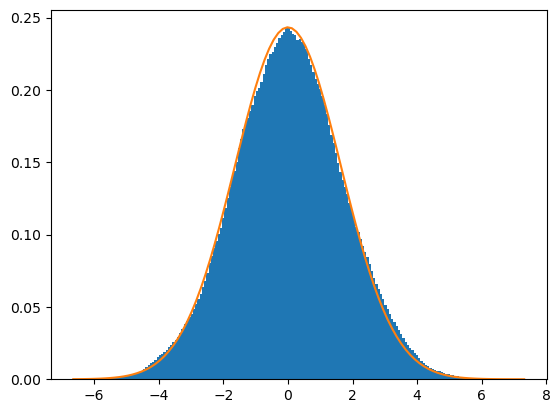

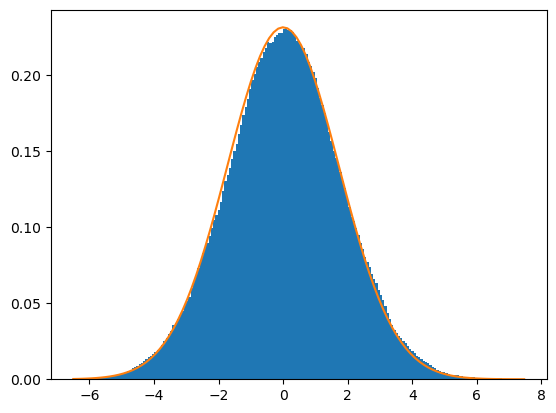

In [65]:
plt.hist(x, bins = 200, density = True)
xspace = np.linspace(np.min(x), np.max(x), 100)
px = fa.probability_x(xspace, expected_cov)
plt.plot(xspace, px)
plt.show()

plt.hist(y, bins = 200, density = True)
yspace = np.linspace(np.min(y), np.max(y), 100)
py = fa.probability_y(yspace, expected_cov)
plt.plot(yspace, py)
plt.show()

In [3]:
Nsteps = int(5e2)
dt = 1e-3

sigma = 1.5
theta_eta = 3.
tau_a = 1.
sigma_a = 0.1
Lambda = 0.9

amean = 1.36585


L, _, _, _, S, I, afluct = fa.find_functional_afluc(Nsteps, dt, sigma, amean, tau_a, sigma_a, theta_eta, Lambda, x0 = 0, y0 = 0, eta0 = 0, tau_x = 1, theta_y = 1)

In [4]:
L

0.24570286337808467

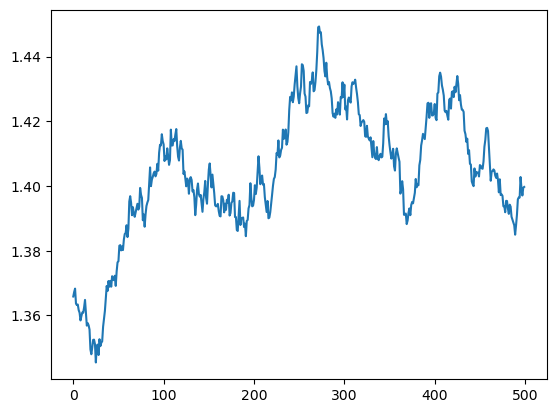

In [5]:
plt.plot(afluct)
plt.show()

# Plots

In [3]:
Nadapt_max = 50000
Nadapt_min = 10000
Ncheck = 5000
Nrepeat = 320
sigma = 1.5
theta_eta = 3.

delta_a = 0.05
Lambda = 0.9

dt = 1e-3

Nsteps_array = np.array([3])
Nsteps_array = 10**Nsteps_array

In [25]:
a_array = np.linspace(0, 1.8, 1000)

In [26]:
a_final = np.zeros((len(Nsteps_array), Nrepeat))

for i in range(len(Nsteps_array)):
    a_adapt = np.load(f'../data/adaptEmp_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    stop_time_adapt = np.load(f'../data/adaptEmp_stopTime_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    print(a_adapt.shape)
    print(a_final.shape)

    for j in range(Nrepeat):
        print(j, stop_time_adapt[j])
        a_curr = a_adapt[j, :stop_time_adapt[j]]
        a_final[i, j] = abs(a_curr[-1])    

(320, 50000)
(1, 320)
0 10001
1 12920
2 10501
3 14373
4 10829
5 14206
6 10001
7 10514
8 10404
9 12856
10 10001
11 10001
12 13299
13 10001
14 15049
15 10001
16 18522
17 10001
18 11542
19 14630
20 14721
21 13833
22 10001
23 10001
24 10113
25 20054
26 13402
27 11481
28 13094
29 17156
30 16720
31 19072
32 10001
33 11598
34 12942
35 13174
36 10001
37 10001
38 11732
39 10001
40 10001
41 10001
42 10001
43 16162
44 11879
45 10001
46 17497
47 12717
48 12620
49 13196
50 11434
51 10001
52 10001
53 10751
54 13857
55 14266
56 10001
57 10001
58 10001
59 10001
60 17713
61 11452
62 12386
63 12427
64 13138
65 10001
66 12180
67 10001
68 10001
69 10001
70 10001
71 10001
72 10001
73 10001
74 16347
75 10256
76 0


IndexError: index -1 is out of bounds for axis 0 with size 0

In [204]:
@njit
def adaptive_dynamics(Nsteps, dt, sigma, theta_eta, Lambda, delta_a,
                      Ncheck = 2000, Nadapt_min = 5000, Nadapt_max = 10000,
                      a_init = 0., tau_x = 1, theta_y = 1, Nburn = 100000,
                      empirical = False, seed = 0):
    
    np.random.seed(seed)
    
    x0_burn, y0_burn, eta0_burn = fa.simulate_xyeta(Nburn, dt, sigma, a_init, theta_eta, tau_x, theta_y)
    x0 = x0_burn[-1]
    y0 = y0_burn[-1]
    eta0 = eta0_burn[-1]

    x0_burn = None
    y0_burn = None
    eta0_burn = None

    L_adapt = np.zeros(Nadapt_max, dtype = np.float64)
    a_adapt = np.zeros(Nadapt_max, dtype = np.float64)
    Ixy_adapt = np.zeros(Nadapt_max, dtype = np.float64)
    Sxy_adapt = np.zeros(Nadapt_max, dtype = np.float64)
    L_adapt[0] = 0.
    a_adapt[0] = a_init

    stop_counter = 0
    stop_time = Nadapt_max

    for idx_adapt in range(1, Nadapt_max):
        a_bar = a_adapt[idx_adapt - 1] + delta_a * np.random.randn()
        if empirical:
            L_bar, x0, y0, eta0, Sxy, Ixy = fa.find_functional_empirical(Nsteps, dt, sigma, a_bar, theta_eta, Lambda, x0, y0, eta0, tau_x, theta_y)
        else:
            L_bar, x0, y0, eta0, Sxy, Ixy = fa.find_functional(Nsteps, dt, sigma, a_bar, theta_eta, Lambda, x0, y0, eta0, tau_x, theta_y)

        Sxy_adapt[idx_adapt] = Sxy
        Ixy_adapt[idx_adapt] = Ixy        

        if L_bar > L_adapt[idx_adapt - 1]:
            a_adapt[idx_adapt] = a_bar
            L_adapt[idx_adapt] = L_bar

            stop_counter = 0
        else:
            a_adapt[idx_adapt] = a_adapt[idx_adapt - 1]
            L_adapt[idx_adapt] = L_adapt[idx_adapt - 1]

            stop_counter += 1

            if idx_adapt > Nadapt_min and stop_counter > Ncheck:
                stop_time = idx_adapt
                break

    return a_adapt, L_adapt, Ixy_adapt, Sxy_adapt, stop_time

In [208]:
a_adapt, L_adapt, Ixy_adapt, Sxy_adapt, stop_time_adapt = adaptive_dynamics(1000, dt, sigma, theta_eta, Lambda, delta_a,
                                                                            Ncheck, Nadapt_min, Nadapt_max, empirical = True, seed = 1)
print(stop_time_adapt)

14475


In [210]:
seeds = np.arange(100)
test_stop_times = np.zeros(len(seeds))
for i in range(len(seeds)):
    a_adapt, L_adapt, Ixy_adapt, Sxy_adapt, stop_time_adapt = adaptive_dynamics(1000, dt, sigma, theta_eta, Lambda, delta_a,
                                                                                Ncheck, Nadapt_min, Nadapt_max, empirical = True, seed = seeds[i])
    test_stop_times[i] = stop_time_adapt
    print(i, stop_time_adapt)

0 11928
1 14475
2 10001
3 10001
4 14103
5 12454
6 10001
7 10001
8 17030
9 12256
10 13788
11 11222
12 11351
13 14892
14 11587
15 18095
16 10001
17 10001
18 10001
19 10001
20 10001
21 10001
22 18438
23 10001
24 15168
25 14745
26 21435
27 10001
28 13164
29 10560
30 10008
31 15074
32 10001
33 11779
34 10001
35 12107
36 14322
37 10001
38 16175
39 12102
40 10001
41 13892
42 10001
43 10001
44 10001
45 13150
46 10001
47 10001
48 10001
49 19627
50 10001
51 10001
52 13066
53 10949
54 10310
55 13836
56 16268
57 10001
58 10001
59 10001
60 10319
61 10067
62 11995
63 10001
64 10001
65 11099
66 11968
67 15174
68 12311
69 10001
70 10001
71 10001
72 10001
73 10001
74 15857
75 10001
76 14232
77 10559
78 10001
79 11870
80 10001
81 10001
82 12203
83 10001
84 10001
85 10001
86 10837
87 12525
88 10001
89 10001
90 10001
91 10113
92 14188
93 10001
94 10001
95 10001
96 11772
97 13619
98 10001
99 16858


In [213]:
test_stop_times.min()

10001.0

In [215]:
a_adapt, L_adapt, Ixy_adapt, Sxy_adapt, stop_time_adapt = fa.repeat_adaptive_dynamics(Nrepeat, 1000, dt, sigma, theta_eta, Lambda, delta_a,
                                                                                      Ncheck, Nadapt_min, Nadapt_max, empirical_cov = True)

In [217]:
stop_time_adapt.min()

10001

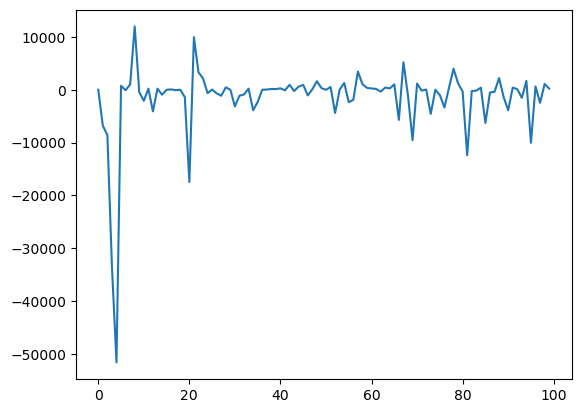

In [81]:
plt.plot(Ixy_adapt[178][:100])

In [218]:
x0_burn, y0_burn, eta0_burn = fa.simulate_xyeta(1000000, dt, sigma, 0., theta_eta, tau_x = 1, theta_y = 1)
x0 = x0_burn[-1]
y0 = y0_burn[-1]
eta0 = eta0_burn[-1]

In [220]:
fa.find_functional_empirical_cov(1000, dt, sigma, 0., theta_eta, Lambda, x0, y0, eta0, tau_x = 1, theta_y = 1)

(-0.18016707813003258,
 -2.0416864226952436,
 0.0004848308188861519,
 -1.20799149904805,
 -1398.5270824807449,
 -355.3773547777522)

In [359]:
Nsteps = 10000
x, y, eta = fa.simulate_xyeta(Nsteps, dt, sigma, 3., theta_eta, 1., 1., x0, y0, eta0)

In [360]:
cov = np.cov(x, y)
det = np.linalg.det(cov)
cov_inv = np.linalg.inv(cov)

print(cov)

Ixy = 0.

for t in range(Nsteps-1):
    pjoint_curr = fa.probability_xy(x[t], y[t], det, cov_inv)
    px_curr = fa.probability_x(x[t], cov)
    py_curr = fa.probability_y(y[t], cov)
    Ixy += np.log(pjoint_curr / (px_curr * py_curr))
Ixy/Nsteps

[[1.09892706 1.42042943]
 [1.42042943 3.82304343]]


0.33737252094054404

In [348]:
@njit(nogil=True, parallel=False)
def hist2d_numba_seq(tracks, bins, ranges):
    H = np.zeros((bins[0], bins[1]), dtype=np.uint64)
    delta = 1 / ((ranges[:, 1] - ranges[:, 0]) / bins)

    for t in range(tracks.shape[1]):
        i = (tracks[0, t] - ranges[0, 0]) * delta[0]
        j = (tracks[1, t] - ranges[1, 0]) * delta[1]
        if 0 <= i < bins[0] and 0 <= j < bins[1]:
            H[int(i), int(j)] += 1

    dx = (ranges[0, 1] - ranges[0, 0]) / bins[0]
    dy = (ranges[1, 1] - ranges[1, 0]) / bins[1]

    return H/np.sum(H*dx*dy)

@njit
def numba_log_zero(array):
    # returns the log of each element of the array, if the element is zero, returns zero
    # the array is 2D
    N = array.shape[0]
    M = array.shape[1]
    out = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            if array[i, j] > 0:
                out[i, j] = np.log(array[i, j])

    return out

@njit
def find_bin(val, bins):
    for i in range(len(bins) - 1):
        if bins[i] <= val < bins[i + 1]:
            return i

    return -1

In [361]:
bins = np.array((100, 100))
ranges = np.array(((np.min(x), np.max(x)), (np.min(y), np.max(y))))

xbins_space = np.linspace(ranges[0, 0], ranges[0, 1], bins[0])
ybins_space = np.linspace(ranges[1, 0], ranges[1, 1], bins[1])

dx = (ranges[0, 1] - ranges[0, 0]) / bins[0]
dy = (ranges[1, 1] - ranges[1, 0]) / bins[1]

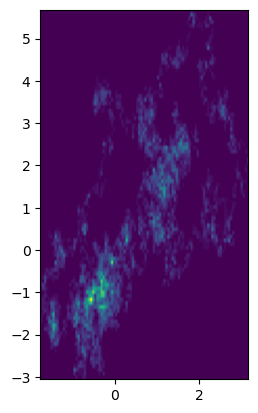

In [362]:
pxy_emp = hist2d_numba_seq(np.array([x,y]), bins=bins, ranges=ranges)

plt.imshow(pxy_emp, extent=(ranges[0, 0], ranges[0, 1], ranges[1, 0], ranges[1, 1]), origin='lower', cmap='viridis')

In [363]:
px_emp = np.sum(pxy_emp*dy, axis = 0)
py_emp = np.sum(pxy_emp*dx, axis = 1)

pxy_factor = np.outer(px_emp, py_emp)

np.sum((numba_log_zero(pxy_emp) - numba_log_zero(pxy_factor))*dx*dy*pxy_emp)

1.6933656202201406

In [364]:
Ixy = 0.

for t in range(Nsteps-1):
    xbin = find_bin(x[t], xbins_space)
    ybin = find_bin(y[t], ybins_space)
    pjoint_curr = pxy_emp[xbin, ybin]
    px_curr = px_emp[xbin]
    py_curr = py_emp[ybin]
    if px_curr * py_curr > 0 and pjoint_curr > 0:
        Ixy += np.log(pjoint_curr / (px_curr * py_curr))
Ixy/Nsteps

1.3930674247019863

In [334]:
expected_cov = fa.cov_matrix(sigma, theta_eta, 3.)
det = np.linalg.det(expected_cov)
cov_inv = np.linalg.inv(expected_cov)

Ixy = 0.

print(expected_cov)

for t in range(Nsteps-1):
    pjoint_curr = fa.probability_xy(x[t], y[t], det, cov_inv)
    px_curr = fa.probability_x(x[t], expected_cov)
    py_curr = fa.probability_y(y[t], expected_cov)
    Ixy += np.log(pjoint_curr / (px_curr * py_curr))

Ixy/Nsteps

[[ 2.6875     5.9296875]
 [ 5.9296875 18.7890625]]


0.5969190343458304

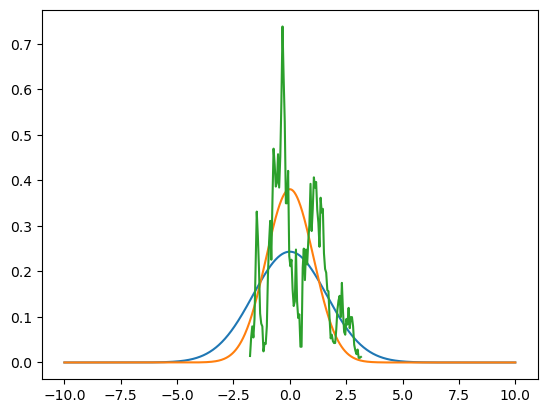

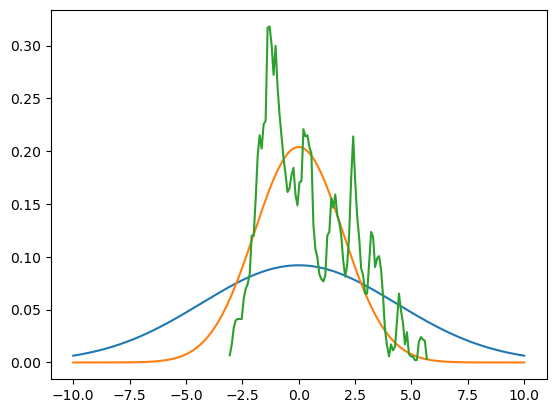

In [365]:
xspace = np.linspace(-10, 10, 1000)
px = fa.probability_x(xspace, expected_cov)
px_emp_cov = fa.probability_x(xspace, cov)
plt.plot(xspace, px)
plt.plot(xspace, px_emp_cov)
plt.plot(xbins_space, px_emp)
plt.plot
plt.show()

yspace = np.linspace(-10, 10, 1000)
py = fa.probability_y(yspace, expected_cov)
py_emp_cov = fa.probability_y(yspace, cov)
plt.plot(yspace, py)
plt.plot(yspace, py_emp_cov)
plt.plot(ybins_space, py_emp)
plt.show()

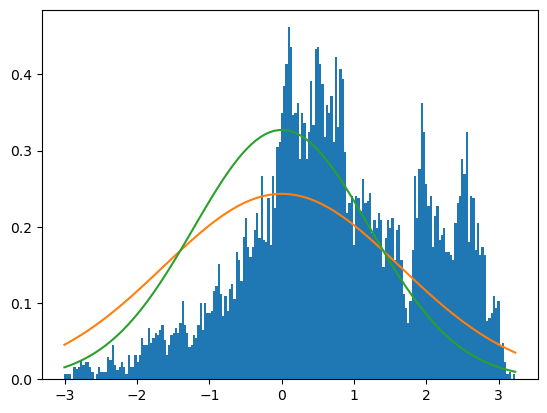

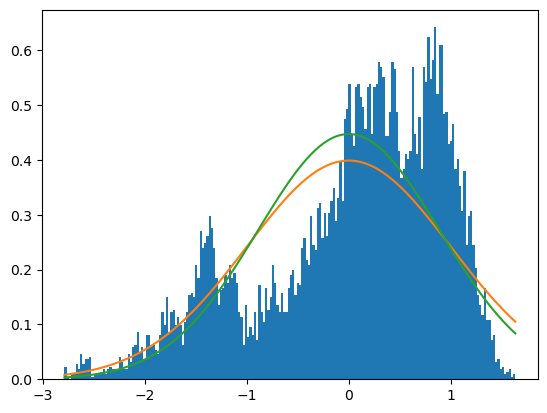

In [145]:
plt.hist(x, bins = 200, density = True)
xspace = np.linspace(np.min(x), np.max(x), 100)
px = fa.probability_x(xspace, expected_cov)
px_emp = fa.probability_x(xspace, cov)
plt.plot(xspace, px)
plt.plot(xspace, px_emp)
plt.show()

plt.hist(y, bins = 200, density = True)
yspace = np.linspace(np.min(y), np.max(y), 100)
py = fa.probability_y(yspace, expected_cov)
plt.plot(yspace, py)
py_emp = fa.probability_y(yspace, cov)
plt.plot(yspace, py_emp)
plt.show()

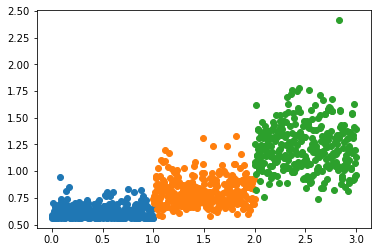

In [51]:
test = fa.Sxy_exact(sigma, a_final, theta_eta)
for i in range(3):
    plt.scatter(np.linspace(i, i+1, Nrepeat), test[i])

In [83]:
atests = np.random.randn(320)+1.36
test = fa.Iyeta_exact(sigma, atests, theta_eta)
test**2/np.var(test)/fa.Sxy_exact(sigma, atests, theta_eta)

array([3.50408255e+00, 1.81105048e+00, 3.29444794e+00, 3.13916940e+00,
       2.00874879e+00, 2.60274372e+00, 3.42709651e+00, 1.77463979e+00,
       3.01668323e+00, 2.67292478e+00, 3.42957426e+00, 3.49827341e+00,
       3.50568816e+00, 2.95515648e+00, 3.00547209e-01, 3.39314139e-02,
       3.48405403e+00, 5.12027679e-02, 2.51576238e+00, 2.42251055e+00,
       1.82364642e+00, 1.49050460e+00, 8.84113777e-01, 3.23906567e+00,
       2.87492523e+00, 3.29092496e+00, 3.33803495e+00, 3.21042730e+00,
       3.29864349e+00, 2.50840610e+00, 1.78634573e+00, 2.39152912e+00,
       3.47025267e+00, 3.05073448e+00, 2.51342092e+00, 2.09855658e+00,
       2.31568448e+00, 3.47321011e+00, 3.16977991e+00, 2.28045275e+00,
       4.28538923e-02, 1.56242040e+00, 2.19484823e+00, 3.08462045e+00,
       9.73581379e-01, 3.50501499e+00, 1.53844910e-01, 1.73697743e+00,
       3.24755713e+00, 3.37705690e+00, 1.18101359e+00, 8.46374753e-02,
       1.62353358e+00, 3.25216086e-03, 2.05400092e+00, 2.01927016e+00,
      

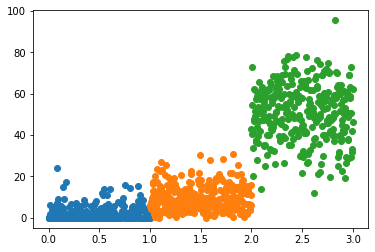

In [62]:
test = fa.Iyeta_exact(sigma, a_final, theta_eta)
test = test**2/np.var(test, axis = 1)[..., None]
for i in range(3):
    plt.scatter(np.linspace(i, i+1, Nrepeat), test[i])

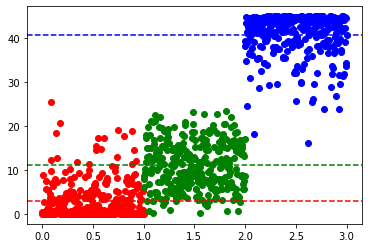

In [74]:
Nstepstests = np.array([1000,10000,100000])
test = fa.Iyeta_exact(sigma, a_final, theta_eta)
test = test**2/np.var(test, axis = 1)[..., None]/fa.Sxy_exact(sigma, a_final, theta_eta)
colors = ['r', 'g', 'b']
for i in range(3):
    plt.scatter(np.linspace(i, i+1, Nrepeat), test[i], c = colors[i])
    plt.axhline(np.mean(test[i]), linestyle = '--', c = colors[i])

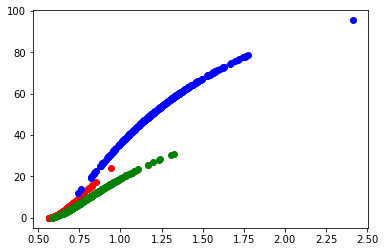

In [90]:
Nstepstests = np.array([1000,10000,100000])
test = fa.Iyeta_exact(sigma, a_final, theta_eta)
test = test**2/np.var(test, axis = 1)[..., None]
colors = ['r', 'g', 'b']
for i in range(3):
    plt.scatter(fa.Sxy_exact(sigma, a_final[i], theta_eta), test[i], c = colors[i])

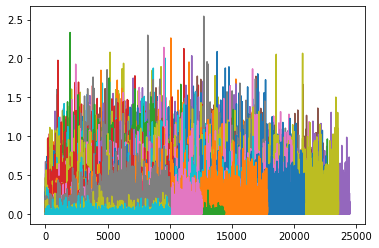

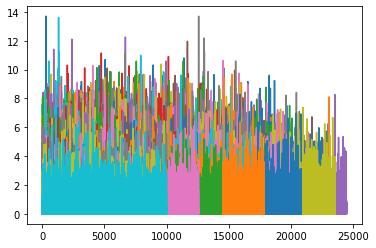

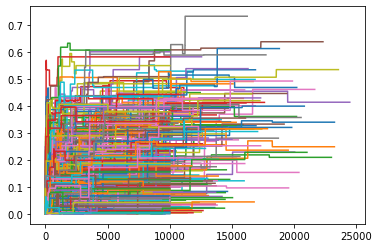

12356.796875 3185.2679438887453
0.23305895093862866 0.1507272958478341


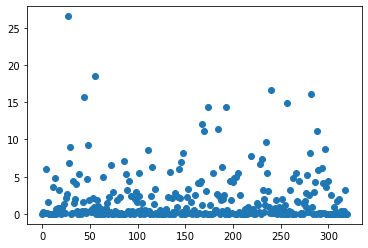

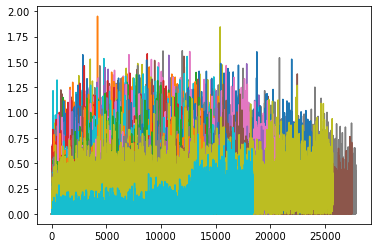

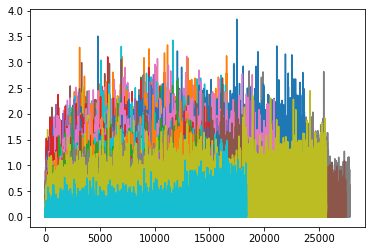

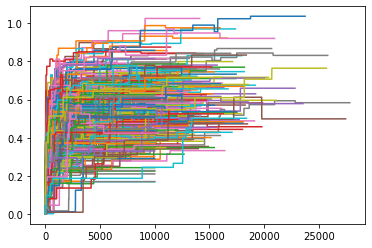

12738.165625 3415.8001214127503
0.5637532259132934 0.15205866165775367


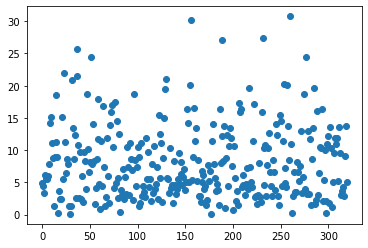

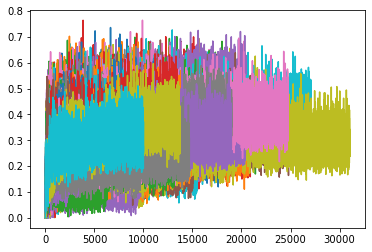

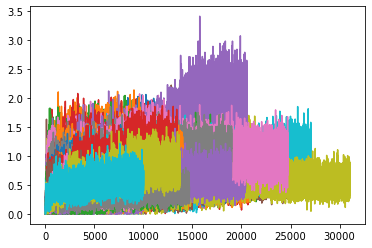

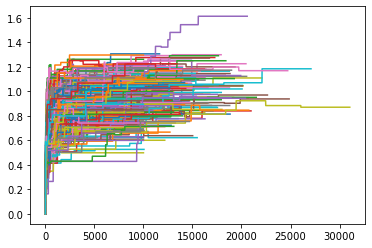

12785.24375 3556.9728144991404
0.9552042285133184 0.15957323074229568


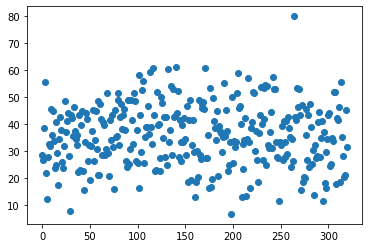

In [42]:
for i in range(3):
    Ixy_adapt = np.load(f'../data/adapt_Ixy_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    Sxy_adapt = np.load(f'../data/adapt_Sxy_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    stop_time_adapt = np.load(f'../data/adapt_stopTime_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')

    Ixy_adapt[Ixy_adapt < 0] = 0
    Sxy_adapt[Sxy_adapt < 0] = 0

    for j in range(Nrepeat):
        Ixy_curr = Ixy_adapt[j, :stop_time_adapt[j]]
        plt.plot(Ixy_curr/(Nsteps_array[i]))
    plt.show()
    
    for j in range(Nrepeat):
        Sxy_curr = Sxy_adapt[j, :stop_time_adapt[j]]
        plt.plot(Sxy_curr/(Nsteps_array[i]))
    plt.show()
    a_final = np.zeros(Nrepeat)
    for j in range(Nrepeat):
        a_curr = a_adapt[j, :stop_time_adapt[j]]
        plt.plot(abs(a_curr))
        a_final[j] = abs(a_curr[-1])
    plt.show()

    print(np.mean(stop_time_adapt), np.std(stop_time_adapt))
    print(np.mean(a_final), np.std(a_final))

    Stot = np.zeros(Nrepeat)
    Iyeta = np.zeros(Nrepeat)
    timetot = np.zeros(Nrepeat)

    for j in range(Nrepeat):
        timetot[j] = Nsteps_array[i]*stop_time_adapt[j]*dt
        Stot[j] = fa.Sxy_exact(sigma, a_final[j], theta_eta)*timetot[j]
        Iyeta[j] = fa.Ixy_exact(sigma, a_final[j], theta_eta)

    plt.scatter(range(Nrepeat),Iyeta**2/np.var(Iyeta))
    plt.show()
    print()

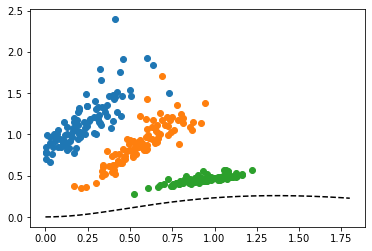

In [14]:
for i in range(3):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    L_adapt = np.load(f'../data/adapt_L_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    stop_time_adapt = np.load(f'../data/adapt_stopTime_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    a_final = np.zeros(Nrepeat)
    L_final = np.zeros(Nrepeat)

    for j in range(Nrepeat):
        a_final[j] = abs(a_adapt[j, stop_time_adapt[j]])
        L_final[j] = L_adapt[j, stop_time_adapt[j]]

    plt.scatter(abs(a_final), L_final)

plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

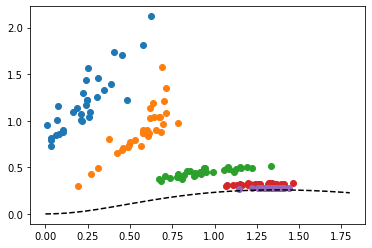

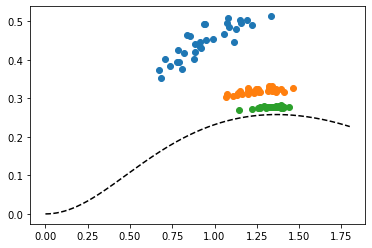

In [27]:
for i in range(5):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')
    L_adapt = np.load(f'../data/adapt_L_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')

    plt.scatter(abs(a_adapt[:,-1]), L_adapt[:,-1])

plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

for i in range(2, 5):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')
    L_adapt = np.load(f'../data/adapt_L_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')

    plt.scatter(abs(a_adapt[:,-1]), L_adapt[:,-1])

plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

0.18544768550532467
0.5175469462023764
0.945869465546001
1.262446686488209
1.3473934513609471


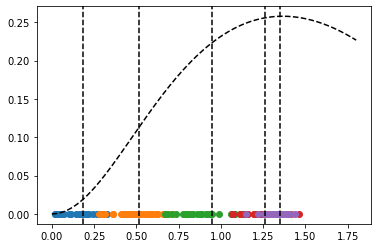

In [18]:
for i in range(5):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')

    plt.scatter(abs(a_adapt[:,-1]), np.zeros(a_adapt.shape[0]))

    plt.axvline(np.mean(abs(a_adapt[:,-1])), color='k', linestyle='--')
    print(np.mean(abs(a_adapt[:,-1])))
plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

0.18544768550532467
0.5175469462023764
0.945869465546001
1.262446686488209
1.3473934513609471


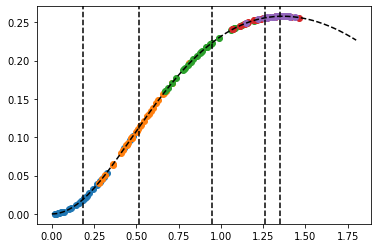

In [19]:
for i in range(5):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')

    plt.scatter(abs(a_adapt[:,-1]), fa.functional_exact(sigma, a_adapt[:,-1], theta_eta, Lambda))

    plt.axvline(np.mean(abs(a_adapt[:,-1])), color='k', linestyle='--')
    print(np.mean(abs(a_adapt[:,-1])))
plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

# Tests

In [8]:
@njit
def simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, x0 = 0, y0 = 0, eta0 = 0):
    x = np.zeros(Nsteps, dtype=np.float64)
    y = np.zeros(Nsteps, dtype=np.float64)
    eta = np.zeros(Nsteps, dtype=np.float64)

    tau_y = theta_y * tau_x
    tau_eta = theta_eta * tau_x
    sqtau_x = np.sqrt(dt/tau_x)
    sqtau_y = np.sqrt(dt/tau_y)
    sqtau_eta = np.sqrt(dt/tau_eta)

    x[0] = x0
    y[0] = y0
    eta[0] = eta0


    for t in range(Nsteps-1):
        y[t + 1] = y[t] + dt * (-y[t] + a * x[t])/tau_y + np.random.randn() * sqtau_y
        x[t + 1] = x[t] + dt * (-x[t] + sigma * eta[t])/tau_x + np.random.randn() * sqtau_x
        eta[t + 1] = eta[t] + dt * (-eta[t])/tau_eta + np.random.randn() * sqtau_eta
        
        
    return x, y, eta

In [120]:
@njit
def cov_matrix(sigma, theta_eta, a):
    theta = 1 + theta_eta
    offdiag = 1/2*a*(1 + theta_eta*sigma**2*(1+2*theta_eta)/theta**2)
    return np.array([[1 + theta_eta*sigma**2/theta,
                      offdiag],
                     [offdiag,
                      1 + a*offdiag]])

@njit
def probability_xy(x, y, det, cov_inv):
    return np.exp(-0.5 * (x**2 * cov_inv[0,0] + y**2 * cov_inv[1,1] + 2*x*y*cov_inv[0,1])) / (2*np.pi*np.sqrt(det))

@njit
def probability_x(x, cov):
    return np.exp(-0.5 * (x**2 / cov[0,0])) / (np.sqrt(2*np.pi*cov[0,0]))

@njit
def probability_y(y, cov):
    return np.exp(-0.5 * (y**2 / cov[1,1])) / (np.sqrt(2*np.pi*cov[1,1]))

@njit
def find_mutual_traj(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, Nburn = 1000000):
    x0, y0, eta0 = simulate_xyeta(Nburn, dt, sigma, a, theta_eta, tau_x, theta_y)
    x, y, _ = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0[-1], y0[-1], eta0[-1])
    x0 = None
    y0 = None

    cov = cov_matrix(sigma, theta_eta, a)
    det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)


    mutual_trajectory = np.zeros(Nsteps, dtype=np.float64)

    for t in range(Nsteps):
        pjoint_curr = probability_xy(x[t], y[t], det, cov_inv)
        px_curr = probability_x(x[t], cov)
        py_curr = probability_y(y[t], cov)
        mutual_trajectory[t] = np.log(pjoint_curr / (px_curr * py_curr))

    return mutual_trajectory, x, y

@njit
def find_Axy(sigma, theta_eta, a):
    theta = 1 + theta_eta

    den = (4 + a**2)*theta**4 + 2*(2+a**2)*theta_eta*theta**3*sigma**2
    den += a**2*theta_eta**2*(theta + theta_eta)*sigma**4

    num1 = 4*theta**4 + a**2*(theta**4 + 2*(theta_eta + theta_eta**2)**2*sigma**2 - theta_eta**2*(theta + theta_eta)*sigma**4)
    num2 = 2*a*theta_eta*theta*sigma**2*(-1+theta_eta**2-theta_eta*sigma**2)

    return np.array([[num1/den, - num2/den],
                     [- a, 1]])

@njit
def find_Sxy_traj(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, Nburn = 1000000):
    x0, y0, eta0 = simulate_xyeta(Nburn, dt, sigma, a, theta_eta, tau_x, theta_y)
    x, y, _ = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0[-1], y0[-1], eta0[-1])
    x0 = None
    y0 = None

    Amat = find_Axy(sigma, theta_eta, a)

    Sx_traj = np.zeros(Nsteps - 1, dtype = np.float64)
    Sy_traj = np.zeros(Nsteps - 1, dtype = np.float64)

    for t in range(Nsteps-1):
        Deltax = x[t+1] - x[t]
        Deltay = y[t+1] - y[t]
        Stratx = 1/2*(x[t+1] + x[t])
        Straty = 1/2*(y[t+1] + y[t])
        Sx_traj[t] = (-Amat[0,0]*Stratx - Amat[0,1]*Straty)*Deltax/dt
        Sy_traj[t] = (-Amat[1,0]*Stratx - Amat[1,1]*Straty)*Deltay/dt

        # Sx_traj[t], Sy_traj[t] = -np.dot(Amat, 1/2*np.array([x[t] + x[t+1] , y[t] + y[t+1]]))*np.array([x[t+1] - x[t] , y[t+1] - y[t]])

    return Sx_traj, Sy_traj

@njit
def find_functional(Nsteps, dt, sigma, a, theta_eta, Lambda, x0, y0, eta0, tau_x = 1, theta_y = 1):
    x, y, eta = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0, y0, eta0)

    Amat = find_Axy(sigma, theta_eta, a)
    cov = cov_matrix(sigma, theta_eta, a)
    det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)

    Sxy = 0.
    Ixy = 0.

    for t in range(Nsteps-1):
        Delta_x = x[t+1] - x[t]
        Delta_y = y[t+1] - y[t]
        Strat_x = 1/2*(x[t+1] + x[t])
        Strat_y = 1/2*(y[t+1] + y[t])

        Sxy += -2*(Amat[0,0]*Strat_x + Amat[0,1]*Strat_y)*Delta_x/dt
        Sxy += -2*(Amat[1,0]*Strat_x + Amat[1,1]*Strat_y)*Delta_y/dt

        pjoint_curr = probability_xy(x[t], y[t], det, cov_inv)
        px_curr = probability_x(x[t], cov)
        py_curr = probability_y(y[t], cov)
        Ixy += np.log(pjoint_curr / (px_curr * py_curr))

    return -(1 - Lambda)*Sxy/(Nsteps - 1) + Lambda*Ixy/(Nsteps - 1), x[-1], y[-1], eta[-1]

In [148]:
@njit
def adaptive_dynamics(Nadapt, Nsteps, dt, sigma, theta_eta, Lambda, delta_a, p_acc = 0.01,
                      a_init = 0., tau_x = 1, theta_y = 1, Nburn = 100000):
    
    x0_burn, y0_burn, eta0_burn = simulate_xyeta(Nburn, dt, sigma, a_init, theta_eta, tau_x, theta_y)
    x0 = x0_burn[-1]
    y0 = y0_burn[-1]
    eta0 = eta0_burn[-1]

    x0_burn = None
    y0_burn = None
    eta0_burn = None

    L_adapt = np.zeros(Nadapt, dtype = np.float64)
    a_adapt = np.zeros(Nadapt, dtype = np.float64)
    L_adapt[0] = 0.
    a_adapt[0] = a_init

    for idx_adapt in range(1, Nadapt):
        a_bar = a_adapt[idx_adapt - 1] + delta_a * np.random.randn()
        L_bar, x0, y0, eta0 = find_functional(Nsteps, dt, sigma, a_bar, theta_eta, Lambda, x0, y0, eta0, tau_x, theta_y)

        if L_bar > L_adapt[idx_adapt - 1]:
            a_adapt[idx_adapt] = a_bar
            L_adapt[idx_adapt] = L_bar
        elif np.random.rand() < p_acc:
            a_adapt[idx_adapt] = a_bar
            L_adapt[idx_adapt] = L_bar
        else:
            a_adapt[idx_adapt] = a_adapt[idx_adapt - 1]
            L_adapt[idx_adapt] = L_adapt[idx_adapt - 1]

    return a_adapt, L_adapt

In [182]:
%%time

Nsteps = int(1e5)
Nadapt = 5000
sigma = 1.7
theta_eta = 1.2
delta_a = 0.05

Lambda = 0.9

dt = 1e-3

a_adapt, L_adapt = adaptive_dynamics(Nadapt, Nsteps, dt, sigma, theta_eta, Lambda, delta_a, p_acc = 0.00)
a_adapt = abs(a_adapt)

CPU times: user 29.3 s, sys: 396 ms, total: 29.7 s
Wall time: 30.2 s


0.8729501753128484


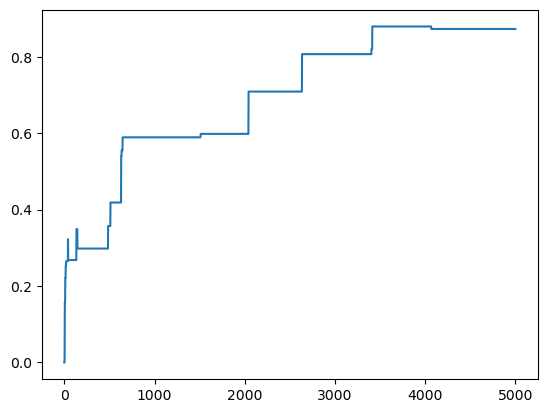

In [183]:
plt.plot(a_adapt)
print(a_adapt[-1])

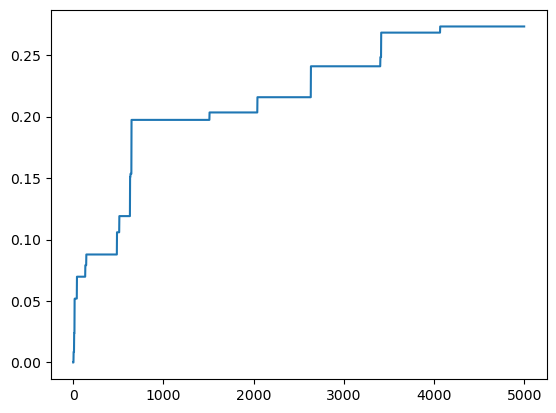

In [184]:
plt.plot(L_adapt)

In [110]:
Nsteps = int(5e5)
sigma = 0.63
theta_eta = 3.2
a = 9.6

Lambda = 0.9

dt = 1e-3

find_functional(Nsteps, dt, sigma, a, theta_eta, Lambda, x0 = 0., y0 = 0., eta0 = 0., tau_x = 1, theta_y = 1)

-4.466689688205942

In [111]:
Nsteps = int(5e7)
sigma = 0.63
theta_eta = 3.2
a = 9.6
dt = 1e-3
Sx_traj, Sy_traj = find_Sxy_traj(Nsteps, dt, sigma, a, theta_eta, Nburn = 100000)

In [100]:
Sx_traj.mean(), Sy_traj.mean()

(-0.043062922122522655, 24.687403456573062)

In [84]:
Nsteps = int(5e7)
sigma = 0.63
theta_eta = 1.2
a = 13.1
dt = 1e-4

MI_traj, xMI, yMI = find_mutual_traj(Nsteps, dt, sigma, a, theta_eta, Nburn = 100000)

In [85]:
MI_traj.mean()

0.39543734152677096

In [74]:
find_Axy(sigma, theta_eta, a)

array([[ 8.20845124e-01,  1.65803590e-04],
       [-1.31000000e+01,  1.00000000e+00]])